# Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from loadData import DataLoader


# Load data

In [2]:
path = '../data-sets/KDD-Cup/data/'

loader = DataLoader(path)

data_df_list = loader.getDataInDfList()

..........................................................................................................................................................................................................................................................

In [3]:
name, data_df = data_df_list[33]

df_train = data_df[data_df['label']=='train']['values'].to_frame()
df_test = data_df[data_df['label']=='test']['values'].to_frame()

print(name)
print('df_train.shape =', df_train.shape)
print('df_test.shape =', df_test.shape)

034_UCR_Anomaly_1500.txt
df_train.shape = (1500, 1)
df_test.shape = (6154, 1)


# Visualization

## Plot of training data (without anomaly)

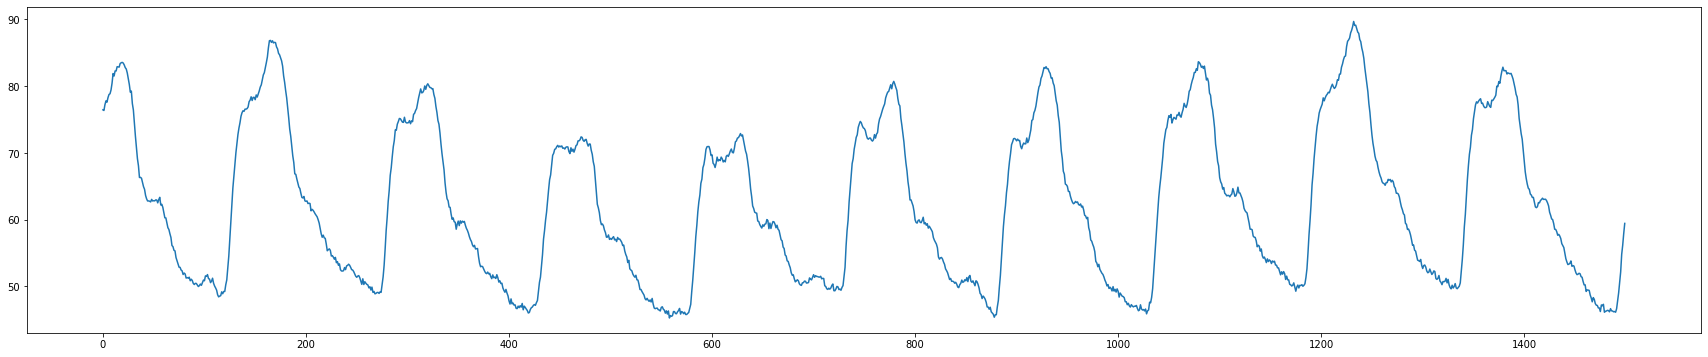

In [4]:

N, M = 30, 6
fig, ax = plt.subplots(figsize=(N, M))
df_train.plot(legend=False, ax=ax)
plt.show()

## Plot of testing data (with anomaly)

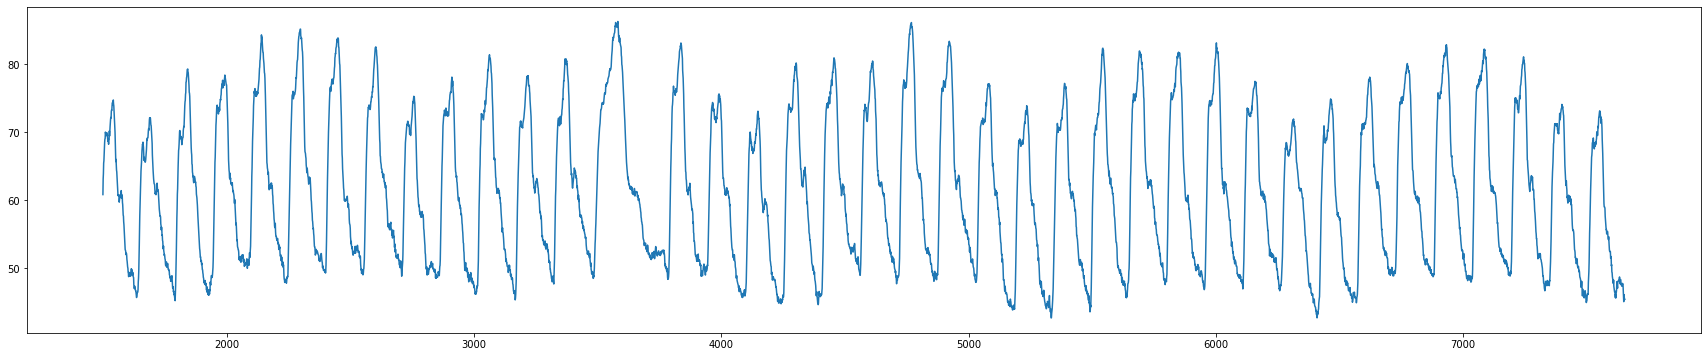

In [5]:

N, M = 30, 6
fig, ax = plt.subplots(figsize=(N, M))
df_test.plot(legend=False, ax=ax)
plt.show()

# Prepare training data

## Normalization

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

display(df_train)

df_training_value

Number of training samples: 1500


,values
0,76.458008
1,76.362195
2,77.233139
3,77.797305
4,77.612248
...,...
1495,52.184675
1496,54.806667
1497,56.179042
1498,57.921033


,values
0,1.215527
1,1.207374
2,1.281481
3,1.329485
4,1.313739
...,...
1495,-0.849837
1496,-0.626737
1497,-0.509965
1498,-0.361743


In [7]:
display(df_train.describe())

df_training_value.describe()

,values
count,1500.000000
mean,62.172443
std,11.752570
min,45.275126
25%,51.324798
50%,59.914537
75%,72.048791
max,89.698638


,values
count,1.500000e+03
mean,-1.136868e-16
std,1.000000e+00
min,-1.437755e+00
25%,-9.230019e-01
50%,-1.921202e-01
75%,8.403565e-01
max,2.342143e+00


## Discretize the Time series data by sliding window

In [8]:
TIME_STEPS = 100 #288

# Generated training sequences for use in the model.

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
x_train

Training input shape:  (1401, 100, 1)


array([[[ 1.21552695],
        [ 1.20737443],
        [ 1.28148112],
        ...,
        [-1.02169586],
        [-0.98667135],
        [-0.95483627]],

       [[ 1.20737443],
        [ 1.28148112],
        [ 1.32948475],
        ...,
        [-0.98667135],
        [-0.95483627],
        [-0.96356423]],

       [[ 1.28148112],
        [ 1.32948475],
        [ 1.31373866],
        ...,
        [-0.95483627],
        [-0.96356423],
        [-0.90093938]],

       ...,

       [[ 0.84235562],
        [ 0.70792468],
        [ 0.58819444],
        ...,
        [-0.84983693],
        [-0.62673747],
        [-0.50996514]],

       [[ 0.70792468],
        [ 0.58819444],
        [ 0.4252551 ],
        ...,
        [-0.62673747],
        [-0.50996514],
        [-0.361743  ]],

       [[ 0.58819444],
        [ 0.4252551 ],
        [ 0.33747285],
        ...,
        [-0.50996514],
        [-0.361743  ],
        [-0.23227565]]])

## Pad zeros in training data

``` python
a = np.arange(12)
display(a)

a = a.reshape((3, 4, 1))
display(a)

data1=np.pad(a, ((0,0), (0,2), (0, 0)), 'constant')
display(data1.shape)

data1
```

In [9]:
x_train_padded_zero = np.pad(x_train, ((0,0), (0,4), (0, 0)), 'constant')
x_train_padded_zero.shape

(1401, 104, 1)

# Build a model

In [10]:
x_train.shape[1], x_train.shape[2]

(100, 1)

In [11]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train_padded_zero.shape[1], x_train_padded_zero.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 52, 32)            256       
_________________________________________________________________
dropout (Dropout)            (None, 52, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 52, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 104, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 104, 1)            2

2021-11-02 00:13:14.908037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train model

In [12]:
history = model.fit(
    x_train_padded_zero,
    x_train_padded_zero,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

2021-11-02 00:13:15.355006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
40/40 [==============================] - 2s 18ms/step - loss: 0.4340 - val_loss: 0.0795
Epoch 2/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0680 - val_loss: 0.0317
Epoch 3/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0398 - val_loss: 0.0180
Epoch 4/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0288 - val_loss: 0.0135
Epoch 5/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0231 - val_loss: 0.0126
Epoch 6/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss: 0.0084
Epoch 7/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0170 - val_loss: 0.0135
Epoch 8/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0107
Epoch 9/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0128 - val_loss: 0.0202
Epoch 10/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0209
Epoch 11/

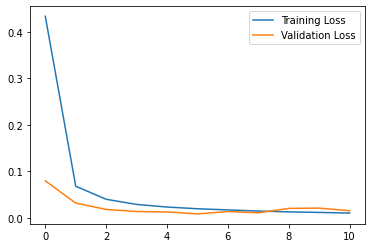

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Detecting anomalies

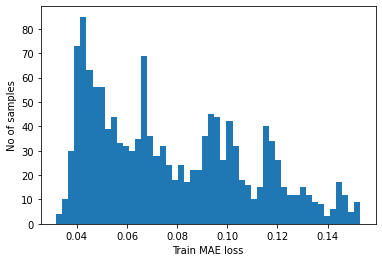

Reconstruction error threshold:  0.15307435583940104


In [14]:
# Get train MAE loss.
x_train_pred = model.predict(x_train_padded_zero)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_padded_zero), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Compare recontruction

### Test with training data

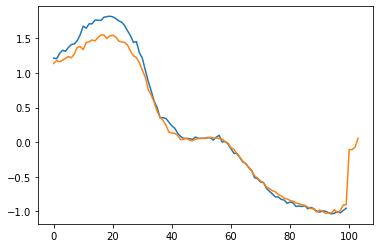

In [15]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

# Test with testing data

##  Prepare test data and predict

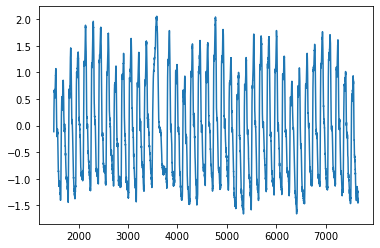

Test input shape:  (6055, 100, 1)
Padded zeros, Test input shape:  (6055, 104, 1)


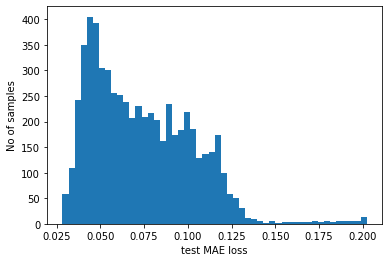

Number of anomaly samples:  70
Indices of anomaly samples:  (array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
       2045, 2046, 2047, 2048]),)


In [16]:
df_test_value = (df_test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Padding zeros to meet autoencoder input-dimension 
x_test = np.pad(x_test, ((0,0), (0,4), (0, 0)), 'constant')
print("Padded zeros, Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [29]:
np.where(anomalies)

(array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
        1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
        2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
        2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
        2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
        2045, 2046, 2047, 2048]),)

# Plot anomalies

In [25]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    print(data_idx - TIME_STEPS + 1, data_idx)
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

anomalous_data_indices

0 99
1 100
2 101
3 102
4 103
5 104
6 105
7 106
8 107
9 108
10 109
11 110
12 111
13 112
14 113
15 114
16 115
17 116
18 117
19 118
20 119
21 120
22 121
23 122
24 123
25 124
26 125
27 126
28 127
29 128
30 129
31 130
32 131
33 132
34 133
35 134
36 135
37 136
38 137
39 138
40 139
41 140
42 141
43 142
44 143
45 144
46 145
47 146
48 147
49 148
50 149
51 150
52 151
53 152
54 153
55 154
56 155
57 156
58 157
59 158
60 159
61 160
62 161
63 162
64 163
65 164
66 165
67 166
68 167
69 168
70 169
71 170
72 171
73 172
74 173
75 174
76 175
77 176
78 177
79 178
80 179
81 180
82 181
83 182
84 183
85 184
86 185
87 186
88 187
89 188
90 189
91 190
92 191
93 192
94 193
95 194
96 195
97 196
98 197
99 198
100 199
101 200
102 201
103 202
104 203
105 204
106 205
107 206
108 207
109 208
110 209
111 210
112 211
113 212
114 213
115 214
116 215
117 216
118 217
119 218
120 219
121 220
122 221
123 222
124 223
125 224
126 225
127 226
128 227
129 228
130 229
131 230
132 231
133 232
134 233
135 234
136 235
137 236
138 237

1169 1268
1170 1269
1171 1270
1172 1271
1173 1272
1174 1273
1175 1274
1176 1275
1177 1276
1178 1277
1179 1278
1180 1279
1181 1280
1182 1281
1183 1282
1184 1283
1185 1284
1186 1285
1187 1286
1188 1287
1189 1288
1190 1289
1191 1290
1192 1291
1193 1292
1194 1293
1195 1294
1196 1295
1197 1296
1198 1297
1199 1298
1200 1299
1201 1300
1202 1301
1203 1302
1204 1303
1205 1304
1206 1305
1207 1306
1208 1307
1209 1308
1210 1309
1211 1310
1212 1311
1213 1312
1214 1313
1215 1314
1216 1315
1217 1316
1218 1317
1219 1318
1220 1319
1221 1320
1222 1321
1223 1322
1224 1323
1225 1324
1226 1325
1227 1326
1228 1327
1229 1328
1230 1329
1231 1330
1232 1331
1233 1332
1234 1333
1235 1334
1236 1335
1237 1336
1238 1337
1239 1338
1240 1339
1241 1340
1242 1341
1243 1342
1244 1343
1245 1344
1246 1345
1247 1346
1248 1347
1249 1348
1250 1349
1251 1350
1252 1351
1253 1352
1254 1353
1255 1354
1256 1355
1257 1356
1258 1357
1259 1358
1260 1359
1261 1360
1262 1361
1263 1362
1264 1363
1265 1364
1266 1365
1267 1366
1268 1367


2169 2268
2170 2269
2171 2270
2172 2271
2173 2272
2174 2273
2175 2274
2176 2275
2177 2276
2178 2277
2179 2278
2180 2279
2181 2280
2182 2281
2183 2282
2184 2283
2185 2284
2186 2285
2187 2286
2188 2287
2189 2288
2190 2289
2191 2290
2192 2291
2193 2292
2194 2293
2195 2294
2196 2295
2197 2296
2198 2297
2199 2298
2200 2299
2201 2300
2202 2301
2203 2302
2204 2303
2205 2304
2206 2305
2207 2306
2208 2307
2209 2308
2210 2309
2211 2310
2212 2311
2213 2312
2214 2313
2215 2314
2216 2315
2217 2316
2218 2317
2219 2318
2220 2319
2221 2320
2222 2321
2223 2322
2224 2323
2225 2324
2226 2325
2227 2326
2228 2327
2229 2328
2230 2329
2231 2330
2232 2331
2233 2332
2234 2333
2235 2334
2236 2335
2237 2336
2238 2337
2239 2338
2240 2339
2241 2340
2242 2341
2243 2342
2244 2343
2245 2344
2246 2345
2247 2346
2248 2347
2249 2348
2250 2349
2251 2350
2252 2351
2253 2352
2254 2353
2255 2354
2256 2355
2257 2356
2258 2357
2259 2358
2260 2359
2261 2360
2262 2361
2263 2362
2264 2363
2265 2364
2266 2365
2267 2366
2268 2367


3131 3230
3132 3231
3133 3232
3134 3233
3135 3234
3136 3235
3137 3236
3138 3237
3139 3238
3140 3239
3141 3240
3142 3241
3143 3242
3144 3243
3145 3244
3146 3245
3147 3246
3148 3247
3149 3248
3150 3249
3151 3250
3152 3251
3153 3252
3154 3253
3155 3254
3156 3255
3157 3256
3158 3257
3159 3258
3160 3259
3161 3260
3162 3261
3163 3262
3164 3263
3165 3264
3166 3265
3167 3266
3168 3267
3169 3268
3170 3269
3171 3270
3172 3271
3173 3272
3174 3273
3175 3274
3176 3275
3177 3276
3178 3277
3179 3278
3180 3279
3181 3280
3182 3281
3183 3282
3184 3283
3185 3284
3186 3285
3187 3286
3188 3287
3189 3288
3190 3289
3191 3290
3192 3291
3193 3292
3194 3293
3195 3294
3196 3295
3197 3296
3198 3297
3199 3298
3200 3299
3201 3300
3202 3301
3203 3302
3204 3303
3205 3304
3206 3305
3207 3306
3208 3307
3209 3308
3210 3309
3211 3310
3212 3311
3213 3312
3214 3313
3215 3314
3216 3315
3217 3316
3218 3317
3219 3318
3220 3319
3221 3320
3222 3321
3223 3322
3224 3323
3225 3324
3226 3325
3227 3326
3228 3327
3229 3328
3230 3329


3970 4069
3971 4070
3972 4071
3973 4072
3974 4073
3975 4074
3976 4075
3977 4076
3978 4077
3979 4078
3980 4079
3981 4080
3982 4081
3983 4082
3984 4083
3985 4084
3986 4085
3987 4086
3988 4087
3989 4088
3990 4089
3991 4090
3992 4091
3993 4092
3994 4093
3995 4094
3996 4095
3997 4096
3998 4097
3999 4098
4000 4099
4001 4100
4002 4101
4003 4102
4004 4103
4005 4104
4006 4105
4007 4106
4008 4107
4009 4108
4010 4109
4011 4110
4012 4111
4013 4112
4014 4113
4015 4114
4016 4115
4017 4116
4018 4117
4019 4118
4020 4119
4021 4120
4022 4121
4023 4122
4024 4123
4025 4124
4026 4125
4027 4126
4028 4127
4029 4128
4030 4129
4031 4130
4032 4131
4033 4132
4034 4133
4035 4134
4036 4135
4037 4136
4038 4137
4039 4138
4040 4139
4041 4140
4042 4141
4043 4142
4044 4143
4045 4144
4046 4145
4047 4146
4048 4147
4049 4148
4050 4149
4051 4150
4052 4151
4053 4152
4054 4153
4055 4154
4056 4155
4057 4156
4058 4157
4059 4158
4060 4159
4061 4160
4062 4161
4063 4162
4064 4163
4065 4164
4066 4165
4067 4166
4068 4167
4069 4168


5046 5145
5047 5146
5048 5147
5049 5148
5050 5149
5051 5150
5052 5151
5053 5152
5054 5153
5055 5154
5056 5155
5057 5156
5058 5157
5059 5158
5060 5159
5061 5160
5062 5161
5063 5162
5064 5163
5065 5164
5066 5165
5067 5166
5068 5167
5069 5168
5070 5169
5071 5170
5072 5171
5073 5172
5074 5173
5075 5174
5076 5175
5077 5176
5078 5177
5079 5178
5080 5179
5081 5180
5082 5181
5083 5182
5084 5183
5085 5184
5086 5185
5087 5186
5088 5187
5089 5188
5090 5189
5091 5190
5092 5191
5093 5192
5094 5193
5095 5194
5096 5195
5097 5196
5098 5197
5099 5198
5100 5199
5101 5200
5102 5201
5103 5202
5104 5203
5105 5204
5106 5205
5107 5206
5108 5207
5109 5208
5110 5209
5111 5210
5112 5211
5113 5212
5114 5213
5115 5214
5116 5215
5117 5216
5118 5217
5119 5218
5120 5219
5121 5220
5122 5221
5123 5222
5124 5223
5125 5224
5126 5225
5127 5226
5128 5227
5129 5228
5130 5229
5131 5230
5132 5231
5133 5232
5134 5233
5135 5234
5136 5235
5137 5236
5138 5237
5139 5238
5140 5239
5141 5240
5142 5241
5143 5242
5144 5243
5145 5244


5944 6043
5945 6044
5946 6045
5947 6046
5948 6047
5949 6048
5950 6049
5951 6050
5952 6051
5953 6052
5954 6053
5955 6054


[]

,values
3479,49.071669
3480,49.431160
3481,49.136521
3482,48.497406
3483,48.472655
...,...
3544,78.114572
3545,78.202028
3546,78.294716
3547,78.642030


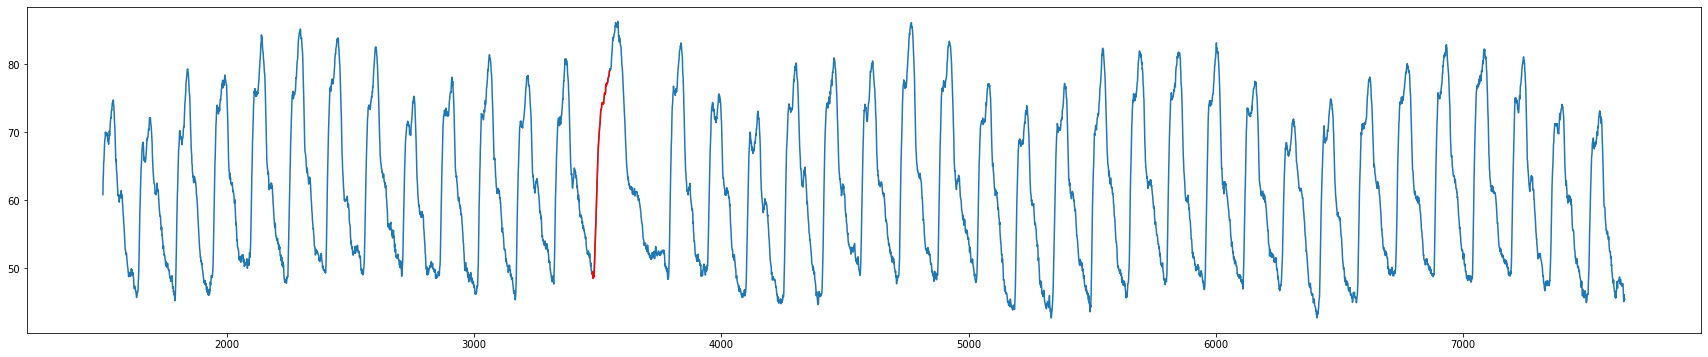

In [30]:
df_subset = df_test.iloc[np.where(anomalies)]
display(df_subset)
N, M = 30, 6
fig, ax = plt.subplots(figsize=(N, M))
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()